# Cat or Dog Classifier
In the previous lessons we have used images that were:
- all the same size
- the object we are interested in were centered in the image
- the images only contained the object of interest
- the images were Greyscale (black and white)

The real world images are __a lot__ messier than this and typically:
- are in colour
- are different sizes
- the object of interest is not always centered
- their may be other objects in the image (that we are not interested in)
- the image may show the object of interest at different angles

This is a harder challenge than either the Digits or Fashion Datasets.

In this workbook we will attempt to build a Classifier that takes an image and categorises it as either containing a cat or a dog. 

We will use the knowledge we have gained in the previous exercise to build a CNN based network to solve classification and evaluate how well it does.

# Importing some packages
We are using the Python programming language and a set of Machine Learning packages - Importing packages for use is a common task. For this workshop you don't really need to pay that much attention to this step (but you do need to execute the cell) since we are focusing on building models. However the following is a description of what this cell does that you can read if you are interested.

### Description of imports (Optional)
You don't need to worry about this code as this is not the focus on the workshop but if you are interested in what this next cell does, here is an explaination.

|Statement|Meaning|
|---|---|
|__import tensorflow as tf__ |Tensorflow (from Google) is our main machine learning library and we performs all of the various calculations for us and so hides much of the detailed complexity in Machine Learning. This _import_ statement makes the power of TensorFlow available to us and for convience we will refer to it as __tf__ |
|__from tensorflow import keras__ |Tensorflow is quite a low level machine learning library which, while powerful and flexible can be confusing so instead we use another higher level framework called Keras to make our machine learning models more readable and easier to build and test. This _import_ statement makes the Keras framework available to us.|
|__import numpy as np__ |Numpy is a Python library for scientific computing and is commonly used for machine learning. This _import_ statement makes the Keras framework available to us.|
|__import matplotlib.pyplot as plt__ |To visualise what is happening in our network we will use a set of graphs and MatPlotLib is the standard Python library for producing Graphs so we __import__ this to enable us to make pretty graphs.|
|__%matplotlib inline__| this is a Jupyter Notebook __magic__ commmand that tells the workbook to produce any graphs as part of the workbook and not as pop-up window.|

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
from keras.preprocessing import image

%matplotlib inline

TensorFlow version is  2.0.0-beta1


Using TensorFlow backend.


## Helper functions
The following cell contains a set of helper functions that makes our models a little clearer. We will not be going through these functions (since they require Python knowlege) so just make sure you have run this cell.

In [3]:
def getCatsAndDogsData():
  # Download and extract the Data Set
  zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                    fname="cats_and_dogs_filtered.zip", extract=True)

  # Grab the location of the unzipped data
  base_dir, _ = os.path.splitext(zip_file)

  # Define the path to the Training and Validation Datasets
  train_dir = os.path.join(base_dir, 'train')
  validation_dir = os.path.join(base_dir, 'validation')

  return train_dir, validation_dir

def getTrainingDirs(train_dir):
  # Directory with our training cat pictures
  train_cats_dir = os.path.join(train_dir, 'cats')
  print ('Total training cat images:', len(os.listdir(train_cats_dir)))

  # Directory with our training dog pictures
  train_dogs_dir = os.path.join(train_dir, 'dogs')
  print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

  return train_cats_dir, train_dogs_dir

def getValidationDirs(validation_dir):
   # Directory with our validation cat pictures
  validation_cats_dir = os.path.join(validation_dir, 'cats')
  print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

  # Directory with our validation dog pictures
  validation_dogs_dir = os.path.join(validation_dir, 'dogs')
  print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

  return validation_cats_dir, validation_dogs_dir

def getCatsAndDogsImageNames(cats_dir, dogs_dir):
  train_cats_names = os.listdir(cats_dir)
  train_dogs_names = os.listdir(dogs_dir)

  return train_cats_names, train_dogs_names


def showImageGrid(image_dir, num_rows=2, num_cols=4):  
  image_labels = os.listdir(image_dir)
  num_pix = num_rows * num_cols
  # Index for iterating over images
  pic_index = 0
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(num_cols * 4, num_rows * 4)

  pic_index += num_pix
  next_pix = [os.path.join(image_dir, fname) 
                  for fname in image_labels[pic_index-num_pix:pic_index]]
  
  for i, img_path in enumerate(next_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(num_rows, num_cols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

  plt.show()

def printLossAndAccuracy(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,max(plt.ylim())])
  plt.title('Training and Validation Loss')
  plt.show()
    
def predictImageContent(model):
  import numpy as np
  from google.colab import files
  from keras.preprocessing import image

  uploaded = files.upload()

  for fn in uploaded.keys():

    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
      print(fn + " is a dog")
    else:
      print(fn + " is a cat")


## Load the Data
The original dataset for this comes from https://www.kaggle.com/c/dogs-vs-cats

However we will use a smaller version of the dataset, this will enable us to train our model quicker rather than spending hours waiting for the training to complete.

The dataset is freely available as a zip file, so we need to download the file and then unzip it to the filesystem. Each image contains either a Cat or a Dog and is stored as a file.
The structure of the unzipped images will be:

`\train
        \train
                \cats
                \dogs
        \validation
                \cats
                \dogs`

The files under the __train__ folder will be used to train the model. This is split into __cats__ and __dogs__

The files under the __validation__ folder will be used to train the model. This is split into __cats__ and __dogs__

In [4]:
train_dir, validation_dir = getCatsAndDogsData()

train_cats_dir, train_dogs_dir = getTrainingDirs(train_dir)
validation_cats_dir, validation_dogs_dir = getValidationDirs(validation_dir)

train_cats_names, train_dogs_names = getCatsAndDogsImageNames(train_cats_dir, train_dogs_dir)

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


## Let's looks at some of the images

Training Cat Images


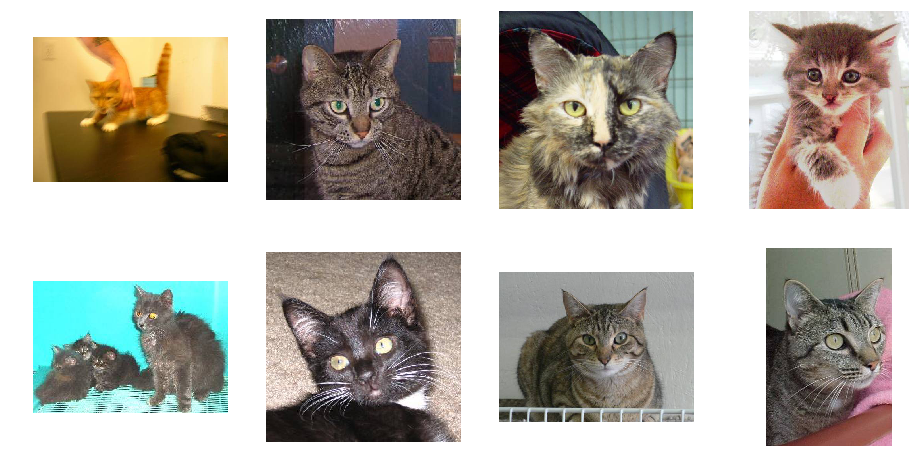

Training Dog Images


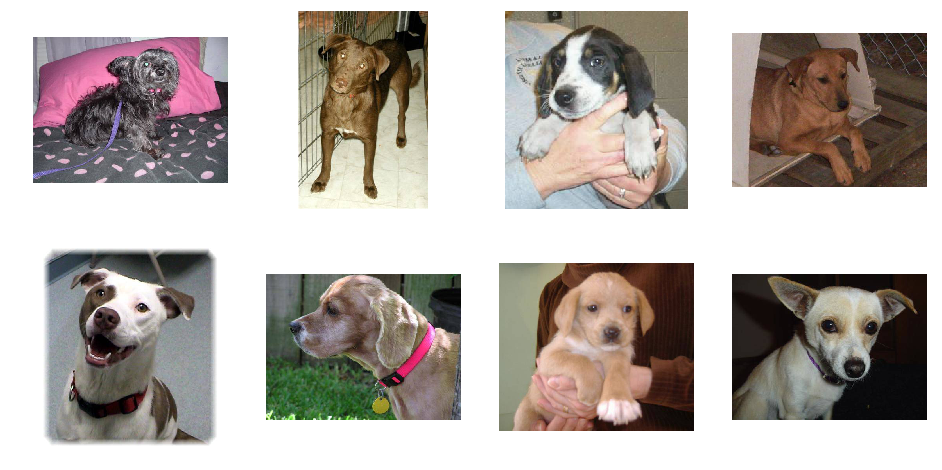

In [5]:
# Display some images from the Training folder
print("Training Cat Images")
showImageGrid(train_cats_dir, num_rows=2, num_cols=4)

print("Training Dog Images")
showImageGrid(train_dogs_dir, num_rows=2, num_cols=4)

You can see from this small sample of images that there is a great deal of variety in the images including:
- different sizes
- different backgrounds
- other objects (such as people's hands) in the image
- images of cats and dogs in different poses and angles

## Introduction to DataGenerators
Previously, we used datasets that were loaded directly into memory as an array of training samples but in the real-world it is more likely that we will have a set of images on a file-system. 

Additionally, given the size of typical image files we would not really want to load all the data into memory before we use it.

Luckily, Keras provides us with a setof  DataGenerator feature that allow use to effectively access training data images from folders as needed rather than reading all data in at once.

In this workbook we will be using the ImageDataGenerator and full details of this feature can be found at https://keras.io/preprocessing/image/

An ImageDataGenerator is a Image Pre-Processor that is designed to take images and prepare them for use in a network and it offers us a range of pre-processing options that are done in memory without affecting the source image on file. This includes:
- Resize the images
- Normalise the data
- Augment the data with random crops and transofmrations of the source image
- Batch the images ready for training.

### Pre-processing the images
The images in the dataset are of different sizes and use RGB (Red, Green, Blue) values between 0 and 255. As before we need to perform some pre-processing to:
- Resize the images to the same size
- Normalize the RGB values to the range 0 to 1

Since our data is already split into training and validation sets we will create two ImageDataGenerators; one for our training data and another for our validation data.

We will construct these ImageDataGenerators to:
- Normalise the data to the range 0 to 1
- Resize the images to 160 x 160
    - Images smaller than 160x160 will be enlarged
    - Images larger than 160x160 will be reduced
    - Non-Square images will be adjusted to be square
- Batch up our images for training

The configuration of the Data Generators might seem complex but hopefully will make sense

### Image Augmentation
ImageDataGenerators also allow us to increase the variety in our images by applying random transformations to our source images. 

This doesn't mean we are altering our source data, instead the ImageDataGenerator randomly selects a batch of images from our file system and loads them into memory. It then randomly applies transformations to the images in memory before passing the transformed image data to the model to use for learning.

Using this technique we can increase the variety of the data we have available to us. For example given an image we can generate variations such as:
- flipping the image vertically
- flipping the image horizontally
- rotating the image
- zooming into the image
- Shifting the image left/right/up/down

Why would we do this?

Augmentation allows us to incease variety in our training data which in turn strenghtens our model and usually leads to better generalisation as it reduces the number of times the same image is cycled through the model. When dealing with real-world images, the more variety we have the better.

The keras `ImageDataGenerator` class allows us to perform some agumentations such as:
- __rescale__ 
- __rotation_range__ specifies the angle range (0-180) to rotate the eimages
- __width_shift_range__ the proportion of the image size to allow the image to shift left or right (from the center)
- __heigh_shift_range__ the proportion of the image size to allow the image to shift up or down (from the center)
- __shear_range__ the proportion of the image to shear the image by
- __zoom_range__ the percentage to zoom in by
- __horizontal_flip__ boolean to allow horizontal flips
- __fill_mode__ the strategy to use to fill any pixels lost by the augmentation (e.g(one option is 'nearest')

You can see the range of options in https://keras.io/preprocessing/image/

For our purposes we will add:
- rescale
- rotation
- flips

To our Image Generator

In [6]:
# We want all our images to be re-sized to 160 x 160 pixels
image_size = 160

# For Training we want to use batches of 32 images at a time
batch_size = 32

### The Training Data Generator
The Training Data Generator will read images in batches from the Training Data folder and perform the pre-processing we need (re-sizing images and normalising the data)

In [7]:
# Training Data Generator with rescale, rotation, zoon and flip data augmentations
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                zoom_range=0.2,
                horizontal_flip=True
                fill_mode='nearest')

# Load Training images from our soruce folder in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size = (image_size, image_size),
                batch_size = batch_size,
                # We are performing a Binary Classification (Cat or Dog)
                class_mode = 'binary')

Found 2000 images belonging to 2 classes.


### The Validation Data Generator
The Validation Data Generator is almost identical to the Training Data Generator except that we obtain the data from a different folder in the file system

In [8]:
# Rescale all images by 1./255 - this shifts our data into the range 0-1
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


# Load Training images from our soruce folder in batches of 32 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                 # We are performing a Binary Classification (Cat or Dog)
                class_mode='binary')

Found 1000 images belonging to 2 classes.


## Define our Network
Now it's time to create our Network

### Exercise
Use your existing knowledge about CNNs and work in your groups to decide what network archiecture you will use and each train a different network to compare the results.

Skeleton code has been provided for you but you will need to add additional layers to attempt to build a good classifer.


In [ ]:
model = tf.keras.models.Sequential()

# Input layer
# TODO: Specify how many filters you want in the first layer
#       Specify the kernel size for this layer - such as (3,3)
model.add(tf.keras.layers.Conv2D(filters=None, kernel_size=(None, None), padding='same',
                                 activation='relu', 
                                 input_shape=(image_size, image_size, 3)))
model.add(tf.keras.layers.MaxPooling2D(strides=(2, 2)))

# Hidden Layer 
# TODO: Specify how many filters you want in the hidden layer 
#        Specify the size of the kernel - for example (3,3)
model.add(tf.keras.layers.Conv2D(filters=None, padding='same', kernel_size=(None, None), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# TODO: Optionally add one or more hidden layers by copying the above 2 lines of code
#       and altering the number of filters, kernal and pool_sizes

# TODO: Optionally add a Dropout layer after some of the Conv2D layers (but before Pooling layers)
# You can add a dropout layer using:
#       model.add(tf.keras.layers.Dropout(0.25))


# Output Layers
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

cnn_model.summary()

## Train your model
Previously we used `model.fit(X_data, y_data)` to train our models and passed in our data as parameters. However, since we are using DataGenerators we need to use a different method that is designed to make use of DataGenerators.

In Keras we can use `model.fit_generator()` to do this and supply the Training DataGenerator. Optionally we can also specify the Validation DataGenerator and other options about how we want training to proceed (such as the number of epochs, steps per epoch)

Full details about the _fit_generator()_ method can be found at https://keras.io/models/model/#fit_generator

In [ ]:
epochs = 20

# Stop early if our Validation Loss stagnates
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,  
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = [early_stop])

In [ ]:
printLossAndAccuracy(history)

## Evaluate the model
__In Practice - Never do this__.

The dataset we used did not have a seperate Testing set so will will evaluate against our validation set. In practice we should not do this as it's not a true measure of how our model generalises but it will give us some indication of accuracy and we are only learning. In our main Image Classification Project you will do this properly :-)


Similar to our Training and Validation ImageDataGenerators we will create a Test ImageDataGenerator and use the `model.evaluate_generator()` method to perform the evaluation against image files.


In [ ]:
# Test Generator
# Rescale all images by 1./255 - this shifts our data into the range 0-1
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


# Load Training images from our soruce folder in batches of 32 using train_datagen generator
test_datagen = test_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                 # We are performing a Binary Classification (Cat or Dog)
                class_mode='binary')

In [ ]:
# Test against our Test Set
loss, accuracy = model.evaluate_generator(test_generator)
print("Test Loss {:.4f}".format(loss))
print("Test Accuracy {:.3f}".format(accuracy))

### Exercise
In groups consider what Human Level Performance should be for this task (i.e. detecting if an image contains a cat or a dog) based on the images you have seen.

Consider how accurate the model is and compare that to your expected Human Level Performance. How well did your model perform?

## Test your Model
The Accuracy gives us a view of how well the model performed against our data, we now need to consider how we might test this model to look for potential issues.

The following cell will allow you to select a file of your own choosing to test our current model.

### Exercise
Think about the task we are trying to solve (detect whether a picture contains a Cat or a Dog) and in your teams consider:
- What images might you use to test whether our classifier correctly classifies an image as a cat or dog.
- Use the cell below to try some images out 
    - you can download images to your machine from sites such as https://pixabay.com/ and run the cell below to load and classify the image - Use Small images if you can (makes the testing a bit faster)
    - Find 1 image of a Cat and 1 image of a Dog that you think your model should easily identify correctly.
    - Find 1 image of a Cat and 1 image of a Dog that you think might be challenging for your model to identify correctly (e.g. a Dog that doesn't look like a dog, or a Cat that looks like a Dog).
    - NOTE: This only works in a CoLab environment.
- Were you able to fool the model in a way that a human would not have been fooled?
    - If so what should we do?

In [ ]:
predictImageContent(cnn_model)